# Дипломный проект

**Описание задачи**

Для оптимизации производственных расходов металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.


**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import warnings
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = 10.0, 6.0
sns.set(color_codes=True)
RS = 111

In [4]:
arc = pd.read_csv('/content/data_arc.csv')
bulk_time = pd.read_csv('/content/data_bulk_time.csv')
bulk = pd.read_csv('/content/data_bulk.csv')
gas = pd.read_csv('/content/data_gas.csv')
temp = pd.read_csv('/content/data_temp.csv')
wire_time = pd.read_csv('/content/data_wire_time.csv')
wire = pd.read_csv('/content/data_wire.csv')

**Описание данных**

* `data_arc.csv` - данные об электродах;
* `data_bulk.csv` - данные о подаче сыпучих материалов (объем);
* `data_bulk_time.csv` - данные о подаче сыпучих материалов (время);
* `data_gas.csv` - данные о продувке сплава газом;
* `data_temp.csv` - результаты измерения температуры;
* `data_wire.csv` - данные о проволочных материалах (объём);
* `data_wire_time.csv` - данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Исследовательский анализ

Перед проведением EDA создадим две функции:

1. `valid_values(data, col)` - функция принимает на вход датафрейм и названия строк. Возвращает минимальные и максимальные допустимые значения по правилу 3-х сигм.
2. `filtered_data(data, cols)` - функция принимает на вход датафрейм и названия строк. Возвращает отфильтрованные датасет, где выбросы устраняются по правилу 3-х сигм.

In [5]:
def valid_values(data, col):
    describe = data[col].describe() #Описательные статистики
    
    Q1, Q3 = describe['25%'], describe['75%'] #Первый и третий квартиль
    
    IQR = Q3 - Q1 #Межквартильный размах
    
    min_allow_value = Q1 - 1.5 * IQR
    max_allow_value = Q3 + 1.5 * IQR
    
    
    if min_allow_value < describe['min']:
        min_allow_value = describe['min'] 
    if max_allow_value > describe['max']:
        max_allow_value = describe['max']
        
    return {'max_av': max_allow_value, 'min_av': min_allow_value}

In [6]:
def filtered_data(data, cols):
    filtered_data = data.copy(deep=True)
    for col in cols:
        filtered_data[col] = filtered_data[col][(filtered_data[col] < valid_values(data, col)['max_av']) &
                                        (filtered_data[col] > valid_values(data, col)['min_av'])]
    return filtered_data.dropna(subset=cols)

### Данные об электродах

Рассмотрим первые пять строк таблицы:

In [7]:
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Выведем основую информацию о таблице:

In [8]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Проверим данные на пропуски:

In [9]:
arc.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Заметим, что данные, описывающие начало и конец нагрева представлены с типом данных `object`. Приведем данные столбцы к типу `datetime`:

In [11]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')

Рассмотрим описательные статистики:

In [12]:
arc.describe().T

,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14876.0,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
Реактивная мощность,14876.0,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388


Можем заметить очевидный выброс: минимальное значение реактивной мощности -715.505.

Построим распределение средней мощности:

In [13]:
arc_power = arc.groupby('key')[['Активная мощность', 'Реактивная мощность']].agg('mean')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf5285bc50>,
      dtype=object)

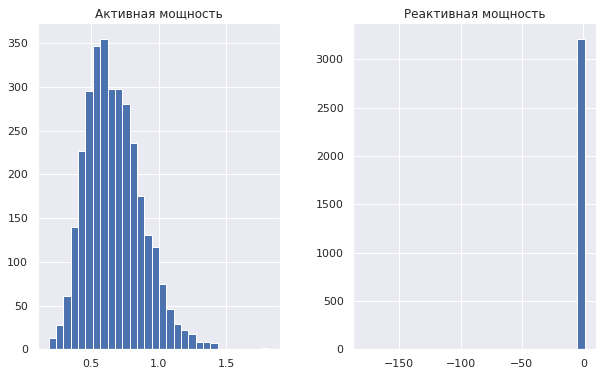

In [14]:
arc_power.hist(bins=30)

Избавимся от выбросов:

In [15]:
for col in ['Активная мощность', 'Реактивная мощность']:
    print(f'Допустимые значения для столбца {col}:\n')
    print('Максимальное допустимое значения:', '{:.2f}'.format(valid_values(arc, col).get('max_av')))
    print('Минимальное допустимое значения:', '{:.2f}'.format(valid_values(arc, col).get('min_av')), '\n')

Допустимые значения для столбца Активная мощность:

Максимальное допустимое значения: 1.55
Минимальное допустимое значения: 0.03 

Допустимые значения для столбца Реактивная мощность:

Максимальное допустимое значения: 1.16
Минимальное допустимое значения: -0.23 



In [16]:
filtered_arc = filtered_data(arc, ['Активная мощность', 'Реактивная мощность'])

Посмотрим, какой процент данных по итогу был утерян:

In [17]:
filtered_arc.shape[0] / arc.shape[0]

0.9524065609034686

Создадим новый датафрейм, содержащий данные о времени нагрева и количестве операций:

In [18]:
filtered_arc['Время нагрева, с'] = (filtered_arc['Конец нагрева дугой'] -
                                    filtered_arc['Начало нагрева дугой']).apply(lambda t: t.seconds)

In [19]:
arc_length = filtered_arc.groupby('key')['Время нагрева, с'].agg(['sum', 'count'])

In [20]:
arc_length

,sum,count
key,,
1,733,4
2,811,4
3,655,5
4,741,4
5,454,3
...,...,...
3237,909,5
3238,546,3
3239,1216,8


In [21]:
final_arc = arc_power.merge(arc_length, how='inner', on='key')

In [22]:
final_arc.columns = ['active', 'reactive', 'arc_length', 'total_start']

In [23]:
final_arc

,active,reactive,arc_length,total_start
key,,,,
1,0.975629,0.636648,733,4
2,0.763150,0.499528,811,4
3,0.505176,0.319815,655,5
4,0.802313,0.515074,741,4
5,0.836793,0.563161,454,3
...,...,...,...,...
3237,0.786493,0.565692,909,5
3238,0.702176,0.560394,546,3
3239,0.583344,0.388952,1216,8


### Данные о подаче сыпучих материалов

Рассмотрим первые пять строк таблиц:

In [24]:
bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [25]:
bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56



Выведем основную информацию о таблицах:

In [26]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Очевидно, что количество пропущенных значений в обоих таблицах будет одинаковым:

In [27]:
bulk.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Пропуски в данных связаны с особенностями технологического процесса.

Рассмотрим описательные статистики:

In [28]:
bulk.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


Заменим пропуски в таблице `bulk` нулем:

In [29]:
bulk = bulk.fillna(0)

Приведем информацию о времени подачи материалов к типу `datetime`:

In [30]:
for col in bulk_time.columns[1:]:
    bulk_time[col] = pd.to_datetime(bulk_time[col], format='%Y-%m-%dT%H:%M:%S')

Сами по себе данные о времени не имеют смысла. Возможно, что время между подачей того или иного материала, может служить информативным признаком для данного технологического процесс - следовательно, сгенерируем такие признаки по каждому материалу:

In [31]:
bulk_time[bulk_time.columns[1:]] = bulk_time[bulk_time.columns[1:]].diff()

In [32]:
for col in bulk_time.columns[1:]:
    bulk_time[col] = bulk_time[col].apply(lambda t: t.seconds)

In [33]:
bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,1508.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2188.0,NaN,2188.0,2188.0
2,3,NaN,NaN,NaN,2668.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1760.0,NaN,1760.0,1760.0
3,4,NaN,NaN,NaN,1057.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1904.0,NaN,1904.0,1904.0
4,5,NaN,NaN,NaN,1807.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1892.0,NaN,1892.0,1892.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,1858.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2097.0,NaN,2097.0,2097.0
3125,3238,NaN,NaN,2863.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2777.0,NaN,2777.0,2777.0
3126,3239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7592.0,NaN,7216.0,7216.0
3127,3240,NaN,NaN,NaN,NaN,NaN,4842.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4082.0,4082.0


Заполним пропуски нулями:

In [34]:
bulk_time = bulk_time.fillna(0)

Изменим названия стобцов для корректности:

In [35]:
bulk_time.columns = ['key'] + [f'Время подачи Bulk {i}' for i in range(1, 16)]

Итоговая таблица:

In [36]:
bulk_time

,key,Время подачи Bulk 1,Время подачи Bulk 2,Время подачи Bulk 3,Время подачи Bulk 4,Время подачи Bulk 5,Время подачи Bulk 6,Время подачи Bulk 7,Время подачи Bulk 8,Время подачи Bulk 9,Время подачи Bulk 10,Время подачи Bulk 11,Время подачи Bulk 12,Время подачи Bulk 13,Время подачи Bulk 14,Время подачи Bulk 15
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,1508.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2188.0,0.0,2188.0,2188.0
2,3,0.0,0.0,0.0,2668.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1760.0,0.0,1760.0,1760.0
3,4,0.0,0.0,0.0,1057.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1904.0,0.0,1904.0,1904.0
4,5,0.0,0.0,0.0,1807.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1892.0,0.0,1892.0,1892.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,1858.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2097.0,0.0,2097.0,2097.0
3125,3238,0.0,0.0,2863.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2777.0,0.0,2777.0,2777.0
3126,3239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7592.0,0.0,7216.0,7216.0
3127,3240,0.0,0.0,0.0,0.0,0.0,4842.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4082.0,4082.0


### Данные о продувке сплава газом

Рассмотрим первые пять строк таблицы:

In [37]:
gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Выведем основную информацию о таблице:

In [39]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Рассмотрим описательные статистики:

In [38]:
gas.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


Построим распределение:

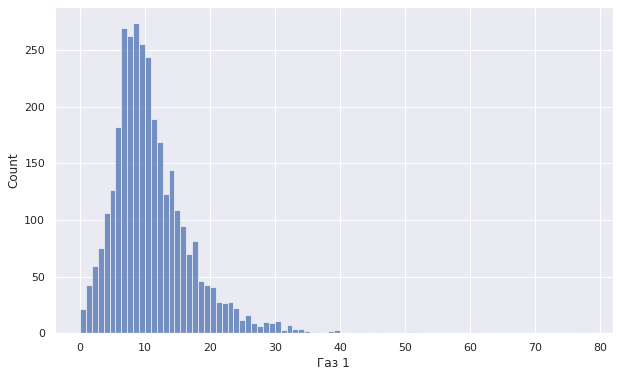

In [40]:
sns.histplot(gas['Газ 1'])

Распределение близко к нормальному, смещено влево. Присутствуют выбросы, однако необходимо уточнять, нужно ли от них избавляться - или же такие показатели обусловены особенностями производства.

### Данные о результатах измерения температуры

Рассмотрим первые пять строк таблицы:

In [41]:
temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Выведем основную информацию о таблице:

In [42]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Рассмотирм описательные статистики:

In [43]:
temp.describe().T

,count,mean,std,min,25%,50%,75%,max
key,15907.0,1607.88087,942.212073,1.0,790.0,1618.0,2427.0,3241.0
Температура,13006.0,1591.84092,21.375851,1191.0,1581.0,1591.0,1601.0,1705.0


Приведем временной параметр к типу `datetime`:

In [44]:
temp['Время замера'] = pd.to_datetime(temp['Время замера'], format='%Y-%m-%dT%H:%M:%S')

Рассмотрим количество пропусков:

In [45]:
temp.isna()

,key,Время замера,Температура
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
15902,False,False,False
15903,False,False,True
15904,False,False,True
15905,False,False,True


Удалим пропуски:

In [46]:
temp = temp.dropna()

Создадим срез, содержащий начальное и конечное значение температуры:

In [47]:
temp_times = temp.groupby('key')['Время замера'].agg(['min', 'max'])
temp_times.columns = ['min_time', 'max_time']

In [48]:
temp_times

,min_time,max_time
key,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39
2,2019-05-03 11:37:27,2019-05-03 11:59:12
3,2019-05-03 12:13:17,2019-05-03 12:34:57
4,2019-05-03 12:52:57,2019-05-03 12:59:25
5,2019-05-03 13:23:19,2019-05-03 13:36:01
...,...,...
3237,2019-08-31 22:44:04,2019-08-31 22:44:04
3238,2019-08-31 23:30:31,2019-08-31 23:30:31
3239,2019-09-01 01:31:47,2019-09-01 01:31:47


На основе полученных данных создадим датафрейм, содержащий начальные и конечные показатели температуры:

In [49]:
start_temp = temp[temp['Время замера'].isin(temp_times['min_time'])].drop('Время замера', axis=1)
stop_temp = temp[temp['Время замера'].isin(temp_times['max_time'])].drop('Время замера', axis=1)

In [50]:
final_temp = start_temp.merge(stop_temp, how='inner', on='key')
final_temp.columns = ['key', 'start_temp', 'final_temp']

In [51]:
final_temp

,key,start_temp,final_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
3211,3237,1569.0,1569.0
3212,3238,1584.0,1584.0
3213,3239,1598.0,1598.0
3214,3240,1617.0,1617.0


Заметим, что в последние строки содержат одинаковые значения - следовательно, нагрева не происходит и некоторые данные пропущены. Избавимся от таких данных:

In [52]:
final_temp = final_temp.query('start_temp != final_temp')

Посмотрим на распределение:

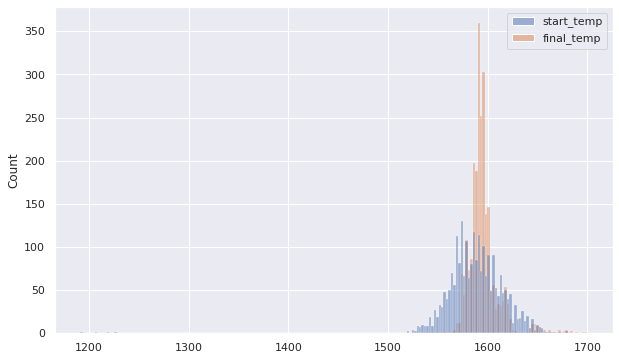

In [53]:
sns.histplot(final_temp[['start_temp', 'final_temp']])

Как и в случае с показателями газа распределение нормальное, значительные выбросы отсутствуют.

### Данные о проволочных материалах

Структура данных в таблицах `wire` и `wire_time` абсолютно такая же, как и в таблицах `bulk` и `bulk_time` - следовательно, произведем над данными таблицами аналогичные операции.

In [54]:
wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [57]:
wire.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [58]:
wire.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442842,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


In [59]:
wire = wire.fillna(0)

In [60]:
for col in wire_time.columns[1:]:
    wire_time[col] = pd.to_datetime(wire_time[col], format='%Y-%m-%dT%H:%M:%S')

In [61]:
wire_time[wire_time.columns[1:]] = wire_time[wire_time.columns[1:]].diff()

In [62]:
wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,0 days 00:34:29,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,0 days 00:27:37,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,0 days 00:34:18,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,0 days 00:30:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
3076,3237,0 days 00:30:37,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,0 days 00:48:04,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,0 days 02:12:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,0 days 01:21:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [63]:
for col in wire_time.columns[1:]:
    wire_time[col] = wire_time[col].apply(lambda t: t.seconds)

In [64]:
wire_time = wire_time.fillna(0)

In [65]:
wire_time.columns = ['key'] + [f'Время подачи Wire {i}' for i in range(1, 10)]

In [66]:
wire_time

,key,Время подачи Wire 1,Время подачи Wire 2,Время подачи Wire 3,Время подачи Wire 4,Время подачи Wire 5,Время подачи Wire 6,Время подачи Wire 7,Время подачи Wire 8,Время подачи Wire 9
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2069.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1657.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2058.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1810.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,1837.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,2884.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,7939.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,4879.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Итоговая таблица

Построим итоговую таблицу с выделенными признаками:

In [67]:
df = final_arc.merge(bulk, how='inner', on='key') \
              .merge(bulk_time, how='inner', on='key') \
              .merge(gas, how='inner', on='key') \
              .merge(final_temp, how='inner', on='key') \
              .merge(wire, how='inner', on='key') \
              .merge(wire_time, how='inner', on='key')

Проверим таблицу на пропуски:

In [68]:
df.isna().sum()

key                     0
active                  0
reactive                0
arc_length              0
total_start             0
Bulk 1                  0
Bulk 2                  0
Bulk 3                  0
Bulk 4                  0
Bulk 5                  0
Bulk 6                  0
Bulk 7                  0
Bulk 8                  0
Bulk 9                  0
Bulk 10                 0
Bulk 11                 0
Bulk 12                 0
Bulk 13                 0
Bulk 14                 0
Bulk 15                 0
Время подачи Bulk 1     0
Время подачи Bulk 2     0
Время подачи Bulk 3     0
Время подачи Bulk 4     0
Время подачи Bulk 5     0
Время подачи Bulk 6     0
Время подачи Bulk 7     0
Время подачи Bulk 8     0
Время подачи Bulk 9     0
Время подачи Bulk 10    0
Время подачи Bulk 11    0
Время подачи Bulk 12    0
Время подачи Bulk 13    0
Время подачи Bulk 14    0
Время подачи Bulk 15    0
Газ 1                   0
start_temp              0
final_temp              0
Wire 1      

In [82]:
df_corr = df.copy()

In [73]:
cols_to_drop = []

for col in df_corr.columns:
    if 'key' in col or 'Время' in col:
        cols_to_drop.append(col)


In [74]:
cols_to_drop

['key',
 'Время подачи Bulk 1',
 'Время подачи Bulk 2',
 'Время подачи Bulk 3',
 'Время подачи Bulk 4',
 'Время подачи Bulk 5',
 'Время подачи Bulk 6',
 'Время подачи Bulk 7',
 'Время подачи Bulk 8',
 'Время подачи Bulk 9',
 'Время подачи Bulk 10',
 'Время подачи Bulk 11',
 'Время подачи Bulk 12',
 'Время подачи Bulk 13',
 'Время подачи Bulk 14',
 'Время подачи Bulk 15',
 'Время подачи Wire 1',
 'Время подачи Wire 2',
 'Время подачи Wire 3',
 'Время подачи Wire 4',
 'Время подачи Wire 5',
 'Время подачи Wire 6',
 'Время подачи Wire 7',
 'Время подачи Wire 8',
 'Время подачи Wire 9']

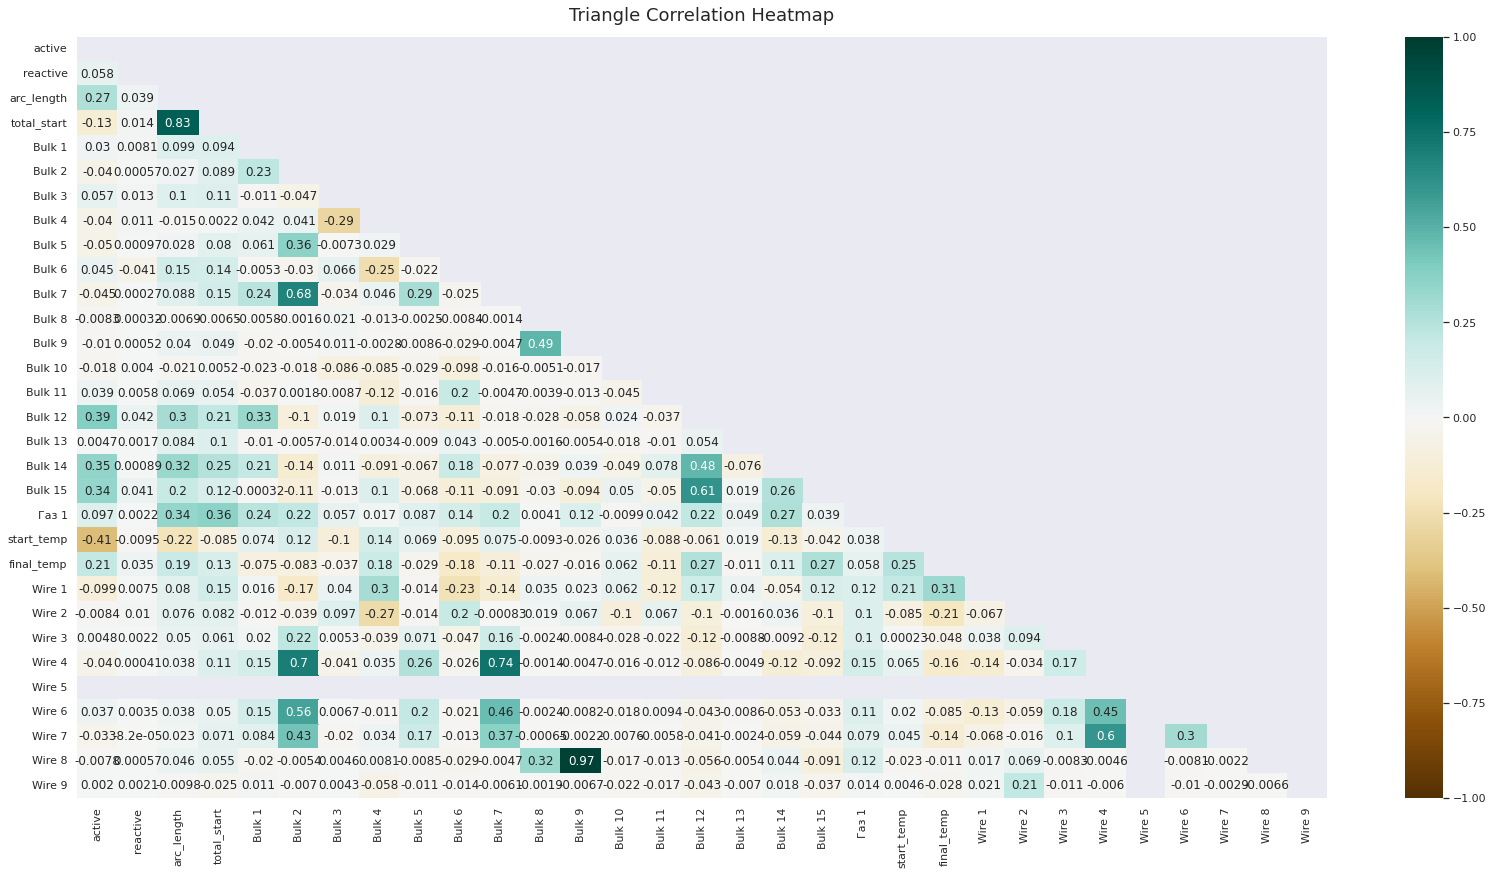

In [95]:
plt.figure(figsize=(28, 14))
mask = np.triu(np.ones_like(df_corr.corr(),
                            dtype=np.bool))
heatmap = sns.heatmap(df_corr.corr(),
                      mask=mask,
                      vmin=-1, vmax=1,
                      annot=True,
                      cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [89]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   active       2293 non-null   float64
 1   reactive     2293 non-null   float64
 2   arc_length   2293 non-null   int64  
 3   total_start  2293 non-null   int64  
 4   Bulk 1       2293 non-null   float64
 5   Bulk 2       2293 non-null   float64
 6   Bulk 3       2293 non-null   float64
 7   Bulk 4       2293 non-null   float64
 8   Bulk 5       2293 non-null   float64
 9   Bulk 6       2293 non-null   float64
 10  Bulk 7       2293 non-null   float64
 11  Bulk 8       2293 non-null   float64
 12  Bulk 9       2293 non-null   float64
 13  Bulk 10      2293 non-null   float64
 14  Bulk 11      2293 non-null   float64
 15  Bulk 12      2293 non-null   float64
 16  Bulk 13      2293 non-null   float64
 17  Bulk 14      2293 non-null   float64
 18  Bulk 15      2293 non-null   float64
 19  Газ 1 

**План работы**:
1. Проведение исследовательского анализа данных, включающего в себя первичную оценку и предобработку данных, генерирование признаков и составление итоговой таблицы для обучения моделей.
2. Построение базовых моделей без подбора параметров, выбор модели.
3. Настройка гиперпараметров оптимальной модели, ее обучение.
4. Оценка эффективности работы модели на тестовых данных.

## Построение моделей машинного обучения

Разобьем данные на тренировочную и тестовую выборку:

In [96]:
df_ml = df.copy()

In [97]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 56 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   2293 non-null   int64  
 1   active                2293 non-null   float64
 2   reactive              2293 non-null   float64
 3   arc_length            2293 non-null   int64  
 4   total_start           2293 non-null   int64  
 5   Bulk 1                2293 non-null   float64
 6   Bulk 2                2293 non-null   float64
 7   Bulk 3                2293 non-null   float64
 8   Bulk 4                2293 non-null   float64
 9   Bulk 5                2293 non-null   float64
 10  Bulk 6                2293 non-null   float64
 11  Bulk 7                2293 non-null   float64
 12  Bulk 8                2293 non-null   float64
 13  Bulk 9                2293 non-null   float64
 14  Bulk 10               2293 non-null   float64
 15  Bulk 11              

In [98]:
df_ml = df_ml.drop(['Wire 8', 'total_start'], axis=1)

In [99]:
X = df_ml.drop('final_temp', axis=1)
y = df_ml['final_temp']

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS)

### Базовые модели

#### Линейная регрессия

In [101]:
model = LinearRegression()

In [102]:
cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=3).mean()

-10.423643188269594

#### Решающее дерево

In [103]:
tree = DecisionTreeRegressor(random_state=RS)

In [104]:
cross_val_score(tree, X_train, y_train, scoring='neg_mean_absolute_error', cv=3).mean()

-8.748109365910414

#### Случайный лес

In [105]:
forest = RandomForestRegressor(random_state=RS)

In [106]:
cross_val_score(forest, X_train, y_train, scoring='neg_mean_absolute_error', cv=3).mean()

-6.344101221640487

#### LightGBM

In [107]:
lgbm = LGBMRegressor()

In [108]:
cross_val_score(lgbm, X_train, y_train, scoring='neg_mean_absolute_error', cv=3).mean()

-6.386172370792479

#### CatBoost

In [109]:
cb = CatBoostRegressor(verbose=False)

In [110]:
cross_val_score(cb, X_train, y_train, scoring='neg_mean_absolute_error', cv=3).mean()

-6.019398315472667

Таким образом, выберем CatBoost для подбора гиперпараметров:

### Подбор гиперпараметров

In [111]:
params = {'iterations': range(1000, 2000, 500),
          'depth': range(5, 12, 3),
          'learning_rate': np.arange(0.01, 0.11, 0.03),
          'verbose': [100]
         }

In [112]:
grid = GridSearchCV(cb, params, scoring='neg_mean_absolute_error', cv=3)

In [113]:
grid.fit(X_train, y_train)

0:	learn: 11.2582571	total: 4.08ms	remaining: 4.07s
100:	learn: 9.5647142	total: 404ms	remaining: 3.6s
200:	learn: 8.6875282	total: 810ms	remaining: 3.22s
300:	learn: 8.1537534	total: 1.24s	remaining: 2.88s
400:	learn: 7.7669650	total: 1.64s	remaining: 2.44s
500:	learn: 7.4576790	total: 2.06s	remaining: 2.05s
600:	learn: 7.2044041	total: 2.45s	remaining: 1.63s
700:	learn: 6.9896262	total: 2.86s	remaining: 1.22s
800:	learn: 6.7967718	total: 3.25s	remaining: 809ms
900:	learn: 6.5918261	total: 3.64s	remaining: 400ms
999:	learn: 6.3874711	total: 4.04s	remaining: 0us
0:	learn: 11.0026138	total: 4.35ms	remaining: 4.34s
100:	learn: 9.3919492	total: 396ms	remaining: 3.52s
200:	learn: 8.5574951	total: 809ms	remaining: 3.21s
300:	learn: 8.0355448	total: 1.2s	remaining: 2.79s
400:	learn: 7.6578649	total: 1.6s	remaining: 2.38s
500:	learn: 7.3533661	total: 2s	remaining: 1.99s
600:	learn: 7.0938423	total: 2.39s	remaining: 1.59s
700:	learn: 6.8601849	total: 2.79s	remaining: 1.19s
800:	learn: 6.633753

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fcf4aea8390>,
             param_grid={'depth': range(5, 12, 3),
                         'iterations': range(1000, 2000, 500),
                         'learning_rate': array([0.01, 0.04, 0.07, 0.1 ]),
                         'verbose': [100]},
             scoring='neg_mean_absolute_error')

Обучим модель на лучших параметрах:

In [115]:
grid.best_params_

{'depth': 5, 'iterations': 1000, 'learning_rate': 0.04, 'verbose': 100}

In [116]:
cb = CatBoostRegressor(**grid.best_params_)

In [117]:
cb.fit(X_train, y_train)

0:	learn: 11.1096117	total: 4.54ms	remaining: 4.54s
100:	learn: 7.8711438	total: 469ms	remaining: 4.17s
200:	learn: 7.0429449	total: 920ms	remaining: 3.66s
300:	learn: 6.4317891	total: 1.38s	remaining: 3.21s
400:	learn: 5.9531760	total: 1.82s	remaining: 2.73s
500:	learn: 5.5519991	total: 2.31s	remaining: 2.3s
600:	learn: 5.1975644	total: 2.76s	remaining: 1.83s
700:	learn: 4.8931650	total: 3.22s	remaining: 1.37s
800:	learn: 4.6182414	total: 3.67s	remaining: 911ms
900:	learn: 4.3443454	total: 4.11s	remaining: 451ms
999:	learn: 4.1302998	total: 4.56s	remaining: 0us


### Тестирование модели

Проверим работу модели на тестовой выборке:

In [118]:
predictions = cb.predict(X_test)

In [119]:
mean_absolute_error(y_test, predictions)

6.132187305993187

Таким образом, было построено несколько базовых моделей, однако наиболее лучшей показала модель градиентного бустинга CatBoost. Для нее методом поиска по сетке были получены оптимальные гиперпараметры, при которых модель давала лучшую метрику на тренировочной выборке. 

Модель также успешно справилась с тестовой выборкой - на неизвестных данных удалось получить метрику **MAE == 6.03**.

## Отчет о проделанной работе

Таким образом, в работе были выполнены все пункты плана:

* Проведен исследовательский анализ данных и выполнена их предобработка: убраны выбросы там, где это необходимо, заполнены пропуски в таблицах. Также удалось сгенерировать несколько фичей, позволяющих улучшить работу модели.
* Построены базовые модели без подбора гиперпараметров: хуже всего с задачей справилась модель линейной регрессии, лучше - модель градиентого бустинга `CatBoost`
* На основе анализа базовых моделей для дальнейшего обучения была выбрана модель `CatBoostRegressor`. Подобраны гиперпараметры методом `GridSearch`. Метрика на тестовых данных составила **5.92**, что более чем удовлетворяет условию поставленной задачи.
* Выполнены предсказания обученной модели на тестовой выборке: результат оказался несколько хуже показателей на тренировочных данных, что и было ожидаемо. Однако, показатель **MAE = 6.03** также считается достаточно высоким/

В процессе выполнения работы наибольшую сложность представлял непосредственно исследовательский анализ. Сложность в описании данных, недостаточные сведения о технологическом процессе - все это препятствовало быстрому решению данной задачи.